<a href="https://colab.research.google.com/github/kkhendry/Benchmarking-Quantum-Groundstate-Solvers/blob/master/main/BenchmarkingTool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To work using VSCode Editor, run cell 1 and 2 below.
Input your own ngrok authentication token in cell 1 and access the VSCode ngrok tunnel by clicking the link in cell 2.

In [ ]:
#@title Cell 1
#%%capture uncomment in google colab to hide output
!pip install colabcode
!wget -q -c -nc https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -qq -n ngrok-stable-linux-amd64.zip
!./ngrok authtoken 20U3834NIEtDeUcn98AGuj8rL7B_3trunaPVasZKZijiuZUCH #add your own authtoken here. Log in/sign up for an ngrok account at https://ngrok.com/.
from colabcode import ColabCode


In [ ]:
#@title Cell 2
ColabCode(port=10000)

To work from google colab, run cell 3. This option is great for running to notebook, but limited for editing helper and utility files and functions.

In [ ]:
#@title Cell 3
#%%capture uncomment in google colab to hide output
!git clone https://github.com/kkhendry/QOSF-2021-Cohort-4-Hydra.git
import sys
sys.path.insert(0, '/content/QOSF-2021-Cohort-4-Hydra/')
%cd QOSF-2021-Cohort-4-Hydra

Run cell 4 and 5 below to set up all the requirements to run the rest of the notebook. When dwave setup prompts you for an authentication token in cell 5, please use your own. You can sign up for a dwave leap account with limited usage at https://cloud.dwavesys.com/leap/login/?next=/leap/.

In [1]:
#@title Cell 4
#%%capture uncomment in google colab to hide output. if using vscode, simply copy and paste the code below in the terminal. For git config add your own email address and user name associated with your github account.
!git config --global user.email karan.khendry@gmail.com
!git config --global user.name hydraken
!pip install -r setup

ers~=2.0 in /usr/local/lib/python3.7/dist-packages (from cirq-core>=0.12.0->openfermion->-r setup (line 3)) (2.4.0)
     |████████████████████████████████| 6.4 MB 31.4 MB/s 
     |████████████████████████████████| 18.0 MB 377 kB/s 
     |████████████████████████████████| 238 kB 77.3 MB/s 
     |████████████████████████████████| 200 kB 65.3 MB/s 
     |████████████████████████████████| 1.4 MB 54.6 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
     |████████████████████████████████| 49 kB 6.6 MB/s 
     |████████████████████████████████| 49 kB 7.3 MB/s 
     |████████████████████████████████| 943 kB 50.2 MB/s 
     |████████████████████████████████| 3.6 MB 36.0 MB/s 
     |████████████████████████████████| 112 kB 84.2 MB/s 
     |████████████████████████████████| 696 kB 70.3 MB/s 
     |████████████████████████████████| 69 kB 7.1 MB/s 
     |████████████████████████████████| 271 kB 91.2 MB/s 
     |████████████████████████████████| 887 kB 65.5 MB/s 
     |██████████████

In [ ]:
#@title Cell 5
#%%capture uncomment in google colab to hide output. if using vscode, simply copy and past the code below in the terminal.
#API Token: DEV-4f5f3a7d07f2dc98dccd35b17cdbaf20b5b7e8cf #use your own dwave Leap API Token
!dwave setup

Install all required modules in cell 6 below.

In [2]:
#@title Cell 6
#General
import numpy as np
import json
import scipy
import scipy.linalg
import math
import time
import re
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import pprint
pp = pprint.PrettyPrinter(indent=2)

#Molecule Drivers
import pyscf
from pyscf import gto, scf, mcscf

##QISKIT
#Molecule, Fermioninc Operator, Problem Definition
from qiskit_nature.drivers import Molecule
from qiskit_nature.operators.second_quantization import FermionicOp
from qiskit_nature.drivers.second_quantization.pyscfd import PySCFDriver
from qiskit_nature.drivers.second_quantization import ElectronicStructureDriverType, ElectronicStructureMoleculeDriver
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem

#Qubit Operator
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, ParityMapper, BravyiKitaevMapper
from qiskit_nature.converters.second_quantization import QubitConverter

#Circuits, Simulators, Algorithms, Solvers and VQE
from qiskit_nature.circuit.library import HartreeFock
from qiskit.circuit.library import EfficientSU2, TwoLocal, NLocal, PauliTwoDesign
from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit_nature.algorithms import GroundStateEigensolver
from qiskit.providers.aer import StatevectorSimulator, QasmSimulator
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP
from qiskit.algorithms import VQE
from qiskit_nature.algorithms import VQEUCCFactory, GroundStateEigensolver

##OPENFERMION
from packages.openfermionpyscf import run_pyscf
from openfermion.transforms import binary_code_transform, bravyi_kitaev_code, get_fermion_operator
from openfermion.ops import FermionOperator, QubitOperator
from openfermion.utils import count_qubits
from openfermion.chem import MolecularData
from openfermion.transforms import get_fermion_operator, jordan_wigner
from openfermion.linalg import get_ground_state, get_sparse_operator
import numpy
import scipy
import scipy.linalg

##UTILITIES
from helper_functions import *
from XBK_method import *
from QCC_method import *

Set up the molecule and electronic structure rpoblem to work with in cell 7 below. Some molecule have been set up below, uncomment the relevant sections to run experiements with those or create an equivalent code block with a molecule of your choice.

In [7]:
#@title Cell 6

#H2
geometry = [['H', [  0.0,    0.0,    0.0]],
            ['H', [  0.0,    0.0,   0.739]]]
molecule = Molecule(geometry=geometry, charge=0, multiplicity=1)
molecule_name = 'H2'
basis = 'sto6g'

# # H3
# geometry = [['H', [0.0, 0.0, 0.0]], ['H', [1.1, 0.0, 0.0]], ['H', [0.55, 0.9526279441628825, 0]]]
# molecule = Molecule(geometry=geometry, charge=1, multiplicity=1)
# molecule_name = 'H3'
# basis = 'sto3g'

# #LiH
# geometry = [['Li', [0.0, 0.0, 0.0]], ['H', [0.0, 0.0, 1.5474]]]
# molecule = Molecule(geometry=geometry, charge=0, multiplicity=1)
# molecule_name = 'LiH'
# basis = 'sto3g'

# # H20
# geometry = [['O', [0.0, 0.0, 0.0]], ['H', [0.0, 0.0, 1.0]], ['H', [0.0, 1.0, 0.0]]]
# molecule = Molecule(geometry=geometry, charge=0, multiplicity=1)
# molecule_name = 'H20'
# basis = 'sto3g'

# #HCONH2
# geometry = [["O",  [1.1280, 0.2091, 0.0000]],
#             ["N", [-1.1878, 0.1791, 0.0000]],
#             ["C", [0.0598, -0.3882, 0.0000]],
#             ["H", [-1.3085, 1.1864, 0.0001]],
#             ["H", [-2.0305, -0.3861, -0.0001]],
#             ["H", [-0.0014, -1.4883, -0.0001]],
#             ['C', [-0.1805, 1.3955, 0.000]]]
# molecule = Molecule(geometry=geometry, charge=0, multiplicity=1)
# molecule_name = 'HCONH2'
# basis = 'sto3g'

class Problem: 
    def __init__(self, molecule, molecule_name, basis, geometry):
        self.molecule = molecule
        self.molecule_name = molecule_name
        self.basis = basis
        self.geometry = str(geometry).replace(" ", "")

    def problemOperators(self, exact_solution = True):
        driver = ElectronicStructureMoleculeDriver(molecule=self.molecule, basis=self.basis, driver_type=ElectronicStructureDriverType.PYSCF)

        self.es_problem = ElectronicStructureProblem(driver)
        self.second_q_op = self.es_problem.second_q_ops()
        self.q_fermionic_op = self.second_q_op[0]
        # register_length = q_fermionic_op.register_length
        self.of_fermionic_op = qiskit2of_fermionicOp(self.q_fermionic_op)

        self.qubit_converter = QubitConverter(JordanWignerMapper())
        self.q_qubit_op = self.qubit_converter.convert(self.q_fermionic_op)
        self.of_qubit_op = jordan_wigner(self.of_fermionic_op)
        # m = count_qubits(qubit_H)
        # print(qubit_H)

        if exact_solution:
            numpy_solver = NumPyMinimumEigensolver()
            numpy_ground_state_solver = GroundStateEigensolver(self.qubit_converter, numpy_solver)
            numpy_results = numpy_ground_state_solver.solve(self.es_problem)
            self.exact_energy = numpy_results.computed_energies[0]
            print(f"Exact electronic energy: {self.exact_energy:.6f} Hartree\n")
            # print(numpy_results)

def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

def minEnergyResults(problem, result_dict, method, backend):
    key = problem.molecule_name+"_"+problem.geometry+"_"+basis+"_"+method+"_"+backend
    fig, ax1 = plt.subplots(1, 1)
    fig.set_figwidth(12)
    fig.set_figheight(9)
    color = 'tab:blue'
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Energy')
    ax1.plot(range(len(result_dict[key]['min energies'])), result_dict[key]['min energies'])
    ax1.axhline(result_dict[key]['exact energy'], linestyle='--')

    # ax2 = ax1.twinx() 
    # color = 'tab:orange'
    # ax2.set_ylabel('Time', color=color)
    # ax2.bar(range(len(min_energies)), iter_times, color=color, alpha = 0.2, width = 0.2)

    if method == 'VQE':
        fig_title = f"\
        {result_dict[key]['setup']['mapping']}-\
        {result_dict[key]['setup']['ansatz']}-\
        {result_dict[key]['setup']['optimizer']}"
        plt.title(method+" Convergence Plot\n"+fig_title)
    elif method == 'QCC':
        fig_title = f"\
        {result_dict[key]['setup']['mapping']}-\
        {result_dict[key]['setup']['angle_folds']}-\
        {result_dict[key]['setup']['amplitude_folds']}"
        plt.title(method+" Convergence Plot\n"+fig_title)
    elif method == 'XBK':
        fig_title = f"\
        {result_dict[key]['setup']['mapping']}-\
        {result_dict[key]['setup']['r']}"
        plt.title(method+" Convergence Plot\n"+fig_title)

    newline = '\n'
    fig.text(0.65, 0.75, f"\
        Minimum Energy: {result_dict[key]['result energy (Ha)']:.3f}{newline}\
        Runtime: {result_dict[key]['runtime']:.3f}{newline}\
        Number of Iterations: {result_dict[key]['# of evaluations']}")

    if os.path.exists('experiments/results.json'):
        with open('experiments/results.json', 'r') as file:
            results = json.loads(file.read())
            results.update(result_dict)
    else:
        with open('experiments/results.json', 'w') as outfile:  
            json.dump({}, outfile)
        results = result_dict

    with open('experiments/results.json','w') as outfile:
        json.dump(results, outfile, sort_keys=True, indent=4)

    fig.savefig('experiments/'+key+'.png')
    pp.pprint(result_dict)

problem = Problem(molecule, molecule_name, basis, geometry)
problem.problemOperators()


Exact electronic energy: -1.862023 Hartree



Set up the IBM Quantum Device backend in cell 7 below. Do not run cell 7 if you would like to use a simulator. Please use your own IBM Quantum authentication API token. You can login/sign up for an IBM Quantum account at https://quantum-computing.ibm.com/

Run cell 8 below to set up the quantum annealer simulator or device. Uncomment as applicable.

In [8]:
#@title Cell 8
from neal import SimulatedAnnealingSampler
sampler = SimulatedAnnealingSampler() #uses simulated annealing, see D-Wave's ocean sdk for more options

# from dwave.system import LeapHybridSampler
# sampler = LeapHybridSampler()

sampler_name = re.search(r'sampler\.(.*?)object', str(sampler)).group(1)

Run cell 9 to get the classical solution for the exact electronic energy, this may not be feasible for large molecules. (Isn't that the point?)

{ "H2_[['H',[0.0,0.0,0.0]],['H',[0.0,0.0,0.739]]]_sto6g_VQE_qasm_simulator": { '# of evaluations': 42,
                                                                               '# of qubits': 4,
                                                                               'accuracy (%)': 90.72291448142869,
                                                                               'backend': 'qasm_simulator',
                                                                               'basis': 'sto6g',
                                                                               'error (mHa)': 0.17274144310544837,
                                                                               'exact energy': -1.8620227522926933,
                                                                               'final parameters': [ -0.44683788596624696,
                                                                                                     0.3247821423875905,
      

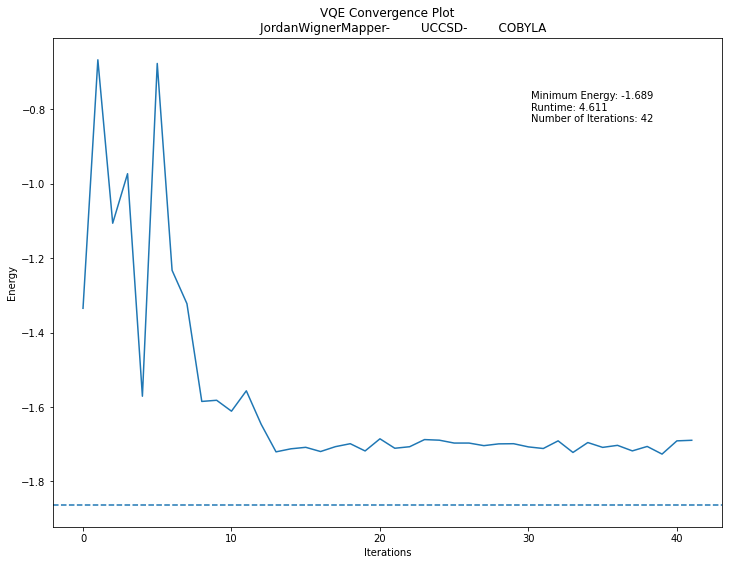

In [9]:
method = "VQE"
init_state = HartreeFock(problem.es_problem.num_spin_orbitals, problem.es_problem.num_particles, problem.qubit_converter)

## Backend
# from qiskit import IBMQ
# IBMQ.save_account('f10a5be117c16a6472c748a25874a94883f6021cf9bfe6f406e015522235a968d8eb0a5812f47160385c72355172371278d3c36e75e23fc7f4d73f1523fcbdf8')
# provider = IBMQ.load_account()
# # provider = IBMQ.get_provider(project='qiskit-runtime')  # Change this to your provider.
# backend = provider.get_backend('ibmq_qasm_simulator')
backend = QasmSimulator()

## Ansatz
from qiskit.circuit.library import TwoLocal
from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD

ansatz_type = "UCCSD"
if ansatz_type == "TwoLocal":
    rotation_blocks = ['ry', 'rz']
    entanglement_blocks = 'cx'
    entanglement = 'full'
    repetitions = 3
    skip_final_rotation_layer = True
    ansatz = TwoLocal(problem.q_qubit_op.num_qubits, rotation_blocks, entanglement_blocks, reps=repetitions, 
                      entanglement=entanglement, skip_final_rotation_layer=skip_final_rotation_layer)
    ansatz.compose(init_state, front=True, inplace=True)
elif ansatz_type == "UCCSD":
    ansatz = UCCSD(problem.qubit_converter,problem.es_problem.num_particles,problem.es_problem.num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "PUCCD":
    ansatz = PUCCD(problem.qubit_converter,problem.es_problem.num_particles,problem.es_problem.num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "SUCCD":
    ansatz = SUCCD(problem.qubit_converter,problem.es_problem.num_particles,problem.es_problem.num_spin_orbitals,initial_state = init_state)

## Optimizer
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP

optimizer_type = 'COBYLA'
if optimizer_type == 'COBYLA':
    optimizer = COBYLA(maxiter=500)
elif optimizer_type == 'L_BFGS_B':
    optimizer = L_BFGS_B(maxfun=500)
elif optimizer_type == 'SPSA':
    optimizer = SPSA(maxiter=500)
elif optimizer_type == 'SLSQP':
    optimizer = SLSQP(maxiter=500)

#how about freeze core, Z2symmetry reduction and removed orbitals?
if ansatz_type == "TwoLocal":
    param_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': problem.qubit_converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': rotation_blocks,
        'entanglement_blocks': entanglement_blocks,
        'entanglement': entanglement,
        'repetitions': repetitions,
        'skip_final_rotation_layer': skip_final_rotation_layer}
else:
    param_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': problem.qubit_converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': None,
        'entanglement_blocks': None,
        'entanglement': None,
        'repetitions': None,
        'skip_final_rotation_layer': None}

np.random.seed(5)  # fix seed for reproducibility
initial_point = np.random.random(ansatz.num_parameters)

iter_times = []
counts = []
values = []
params = []
deviation = []

algorithm = VQE(ansatz,
                optimizer=optimizer,
                quantum_instance=backend,
                callback=callback,
                initial_point=initial_point)

result = algorithm.compute_minimum_eigenvalue(problem.q_qubit_op)
exact_energy = problem.exact_energy
min_energy = np.real(result.eigenvalue)
optimal_state = result.eigenstate
optimal_point = result.optimal_point
percent_accuracy = 100-np.abs(100*(min_energy-exact_energy)/exact_energy)
nominal_accuracy = min_energy-exact_energy
min_energies = values
key = problem.molecule_name+"_"+problem.geometry+"_"+basis+"_"+method+"_"+str(backend)

result_dict = {
    key:
        {
        'molecule': problem.molecule_name,
        'geometry': problem.geometry,
        'basis': problem.basis,
        'method': method,
        'backend': str(backend),
        'setup' : param_dict,
        'exact energy': problem.exact_energy,
        'result energy (Ha)': min_energy,
        'error (mHa)': nominal_accuracy,
        'accuracy (%)': percent_accuracy,
        'final parameters': list(optimal_point),
        '# of evaluations': len(min_energies),
        'runtime': result.optimizer_time,
        '# of qubits': int(problem.q_qubit_op.num_qubits),
        'min energies': list(min_energies)
        }
}

minEnergyResults(problem, result_dict, method, str(backend))

Cycle: 1 Energy: 1.4911326814180939
Cycle: 2 Energy: 1.1678520807181485
Cycle: 3 Energy: 0.5045382685493678
Cycle: 4 Energy: 1.2706174870836549
Cycle: 5 Energy: -0.13194259739248082
Cycle: 6 Energy: -0.36833506055700127
Cycle: 7 Energy: -0.9138990847568493
Cycle: 8 Energy: 0.35245779177057557
Cycle: 9 Energy: -0.504538268520264
Cycle: 10 Energy: -0.4883208222745452
{ "H2_[['H',[0.0,0.0,0.0]],['H',[0.0,0.0,0.739]]]_sto6g_QCC_SimulatedAnnealingSampler ": { '# of evaluations': 10,
                                                                                           '# of qubits': 4,
                                                                                           'accuracy (%)': 49.08098376518616,
                                                                                           'backend': 'SimulatedAnnealingSampler ',
                                                                                           'basis': 'sto6g',
                                         

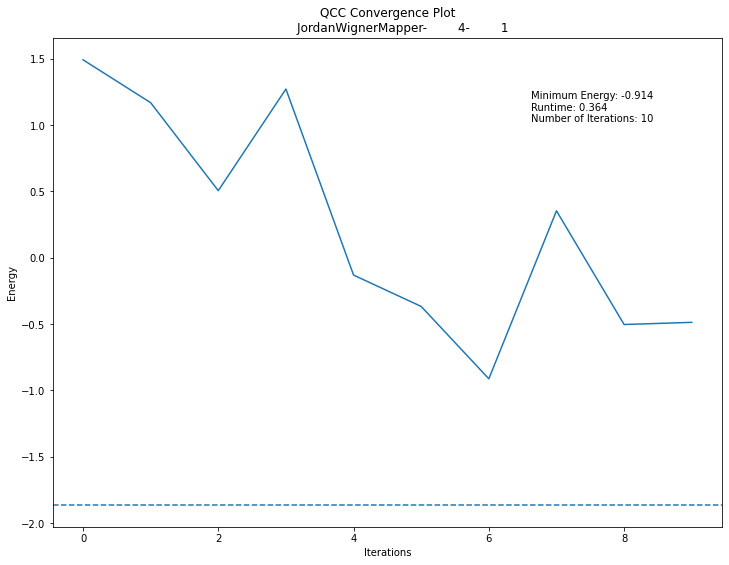

In [10]:
### QCC method ###
#set number of Bloch angle and entangler amplitude foldings
method = 'QCC'
start_time = time.time()

angle_folds = 4
amplitude_folds = 1
m = count_qubits(problem.of_qubit_op)
#create dictionary of QubitOperator entanglers
entanglers = {'IYZI': QubitOperator('Y1 Z2'), 'IZYI': QubitOperator('Z1 Y2'),
              'IXYI': QubitOperator('X1 Y2'), 'IYXI': QubitOperator('Y1 X2')}

param_dict = {
    'mapping': problem.qubit_converter.mapper.__class__.__name__,
    'angle_folds': angle_folds,
    'amplitude_folds': amplitude_folds,
    'entanglers': str(entanglers)}

#run QCC method
min_energy, variables, min_energies, iter_times = QCC(problem.of_qubit_op, entanglers, angle_folds, amplitude_folds, sampler, num_cycles=10, num_samples=1000, strength=1e3, verbose=True)

exact_energy = problem.exact_energy
min_energy = np.real(min_energy)
optimal_point = variables
percent_accuracy = 100-np.abs(100*(min_energy-exact_energy)/exact_energy)
nominal_accuracy = min_energy-exact_energy
key = problem.molecule_name+"_"+problem.geometry+"_"+basis+"_"+method+"_"+sampler_name

result_dict = {
    key:
        {
        'molecule': problem.molecule_name,
        'geometry': problem.geometry,
        'basis': problem.basis,
        'method': method,
        'backend': sampler_name,
        'setup' : param_dict,
        'exact energy': exact_energy,
        'result energy (Ha)': min_energy,
        'error (mHa)': nominal_accuracy,
        'accuracy (%)': percent_accuracy,
        'final parameters': str(optimal_point),
        '# of evaluations': len(min_energies),
        'runtime': sum(iter_times),
        '# of qubits': m,
        'min energies': list(min_energies)
        }

}

minEnergyResults(problem, result_dict, method, sampler_name)

P: 0 E: 0
P: 1 E: -0.47006
P: 2 E: -1.22216
Energy: -1.22216
{ "H2_[['H',[0.0,0.0,0.0]],['H',[0.0,0.0,0.739]]]_sto6g_XBK_SimulatedAnnealingSampler ": { '# of evaluations': 3,
                                                                                           '# of qubits': 4,
                                                                                           'accuracy (%)': 65.63630346701515,
                                                                                           'backend': 'SimulatedAnnealingSampler ',
                                                                                           'basis': 'sto6g',
                                                                                           'error (mHa)': 0.6398598479729933,
                                                                                           'exact energy': -1.8620227522926933,
                                                                                           'fin

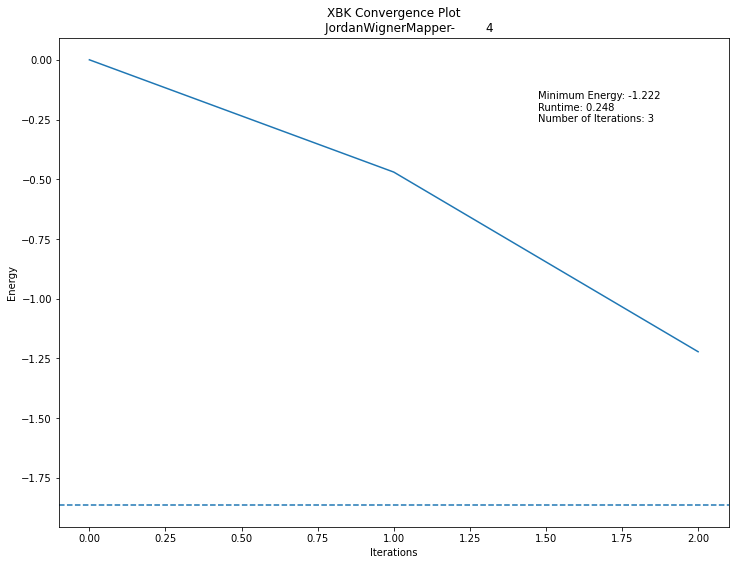

In [11]:
### XBK method ###
method = 'XBK'
start_time = time.time()
#set r value
r = 4

#construct qubit Hamiltonians and C terms for XBK method
qubit_Hs, qubit_Cs = [],[]
m = count_qubits(problem.of_qubit_op)
for p in range(int(math.ceil(r/2+1))):
    qubit_Hs += [XBK_transform(problem.of_qubit_op, r, p)]
    qubit_Cs += [construct_C(m, r, p)]

param_dict = {
    'mapping': problem.qubit_converter.mapper.__class__.__name__,
    'r': r}

#run XBK method
min_energy, ground_state, min_energies, iter_times = XBK(qubit_Hs, qubit_Cs, r, sampler, starting_lam=0, num_samples=1000, strength=1e3, verbose=True)

exact_energy = problem.exact_energy
min_energy = np.real(min_energy)
optimal_state = ground_state
percent_accuracy = 100-np.abs(100*(min_energy-exact_energy)/exact_energy)
nominal_accuracy = min_energy-exact_energy
key = problem.molecule_name+"_"+problem.geometry+"_"+basis+"_"+method+"_"+sampler_name

result_dict = {
    key:
        {
        'molecule': problem.molecule_name,
        'geometry': problem.geometry,
        'basis': problem.basis,
        'method': method,
        'backend': sampler_name,
        'setup' : param_dict,
        'exact energy': problem.exact_energy,
        'result energy (Ha)': min_energy,
        'error (mHa)': nominal_accuracy,
        'accuracy (%)': percent_accuracy,
        'final parameters': 'N/A',
        '# of evaluations': len(min_energies),
        'runtime': sum(iter_times),
        '# of qubits': m,
        'min energies': min_energies
        }
}

minEnergyResults(problem, result_dict, method, sampler_name)

In [13]:
with open('experiments/results.json', 'r') as file:
    results = json.loads(file.read())

import pandas as pd
result_df = pd.DataFrame.from_dict(results, orient="index")
result_df

,# of evaluations,# of qubits,accuracy (%),backend,basis,error (mHa),exact energy,final parameters,geometry,method,min energies,molecule,result energy (Ha),runtime,setup
"H2_[['H',[0.0,0.0,0.0]],['H',[0.0,0.0,0.739]]]_sto6g_QCC_LeapHybridSampler",10,4,81.021341,LeapHybridSampler,sto6g,0.353387,-1.862023,"{phi0: 1.511113415759232, phi1: 6.283185307179...","[['H',[0.0,0.0,0.0]],['H',[0.0,0.0,0.739]]]",QCC,"[-1.5086358099651989, -1.5086358099651989, -1....",H2,-1.508636,72.941867,"{'amplitude_folds': 1, 'angle_folds': 4, 'enta..."
"H2_[['H',[0.0,0.0,0.0]],['H',[0.0,0.0,0.739]]]_sto6g_QCC_SimulatedAnnealingSampler",10,4,49.080984,SimulatedAnnealingSampler,sto6g,0.948124,-1.862023,"{phi0: 0.2942922831505221, phi1: 6.28318530717...","[['H',[0.0,0.0,0.0]],['H',[0.0,0.0,0.739]]]",QCC,"[1.4911326814180939, 1.1678520807181485, 0.504...",H2,-0.913899,0.364218,"{'amplitude_folds': 1, 'angle_folds': 4, 'enta..."
"H2_[['H',[0.0,0.0,0.0]],['H',[0.0,0.0,0.739]]]_sto6g_VQE_ibmq_qasm_simulator",43,4,98.874701,ibmq_qasm_simulator,sto6g,0.020953,-1.862023,"[0.12014802529957237, 0.011163512751058832, 0....","[['H',[0.0,0.0,0.0]],['H',[0.0,0.0,0.739]]]",VQE,"[-1.3422368784782632, -0.6789554492251058, -1....",H2,-1.841069,1532.344960,"{'ansatz': 'UCCSD', 'entanglement': None, 'ent..."
"H2_[['H',[0.0,0.0,0.0]],['H',[0.0,0.0,0.739]]]_sto6g_VQE_qasm_simulator",42,4,90.722914,qasm_simulator,sto6g,0.172741,-1.862023,"[-0.44683788596624696, 0.3247821423875905, -0....","[['H',[0.0,0.0,0.0]],['H',[0.0,0.0,0.739]]]",VQE,"[-1.3346168598242034, -0.6668234023713342, -1....",H2,-1.689281,4.611108,"{'ansatz': 'UCCSD', 'entanglement': None, 'ent..."
"H2_[['H',[0.0,0.0,0.0]],['H',[0.0,0.0,0.739]]]_sto6g_XBK_LeapHybridSampler",3,4,98.947249,LeapHybridSampler,sto6g,0.019602,-1.862023,N/A,"[['H',[0.0,0.0,0.0]],['H',[0.0,0.0,0.739]]]",XBK,"[-1.64644295169079, -1.84242029838206, -1.6187...",H2,-1.842420,22.623194,"{'mapping': 'JordanWignerMapper', 'r': 4}"
"H2_[['H',[0.0,0.0,0.0]],['H',[0.0,0.0,0.739]]]_sto6g_XBK_SimulatedAnnealingSampler",3,4,65.636303,SimulatedAnnealingSampler,sto6g,0.639860,-1.862023,N/A,"[['H',[0.0,0.0,0.0]],['H',[0.0,0.0,0.739]]]",XBK,"[0, -0.47006001921545, -1.2221629043197]",H2,-1.222163,0.247912,"{'mapping': 'JordanWignerMapper', 'r': 4}"
"H3_[['H',[0.0,0.0,0.0]],['H',[1.1,0.0,0.0]],['H',[0.55,0.9526279441628825,0]]]_sto3g_QCC_LeapHybridSampler",10,6,88.912593,LeapHybridSampler,sto3g,0.314530,-2.836820,"{phi0: 6.283185307179586, phi1: 2.026536419279...","[['H',[0.0,0.0,0.0]],['H',[1.1,0.0,0.0]],['H',...",QCC,"[-2.471447810472455, -2.5191162675619125, -2.5...",H3,-2.522290,77.630597,"{'amplitude_folds': 1, 'angle_folds': 4, 'enta..."
"H3_[['H',[0.0,0.0,0.0]],['H',[1.1,0.0,0.0]],['H',[0.55,0.9526279441628825,0]]]_sto3g_VQE_ibmq_qasm_simulator",104,6,95.056505,ibmq_qasm_simulator,sto3g,0.140238,-2.836820,"[0.012941608396504004, 1.650779961674835, 0.03...","[['H',[0.0,0.0,0.0]],['H',[1.1,0.0,0.0]],['H',...",VQE,"[-2.245116269753418, -2.0568043590859917, -1.9...",H3,-2.696582,2706.614303,"{'ansatz': 'UCCSD', 'entanglement': None, 'ent..."
"H3_[['H',[0.0,0.0,0.0]],['H',[1.1,0.0,0.0]],['H',[0.55,0.9526279441628825,0]]]_sto3g_XBK_LeapHybridSampler",3,6,0.000000,LeapHybridSampler,sto3g,2.836820,-2.836820,N/A,"[['H',[0.0,0.0,0.0]],['H',[1.1,0.0,0.0]],['H',...",XBK,"[0, 0, 0]",H3,0.000000,36.284763,"{'mapping': 'JordanWignerMapper', 'r': 4}"
